In [152]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd,jacrev
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *

from scipy.integrate import solve_ivp
from jax.scipy.linalg import block_diag

from jax.scipy.linalg import solve

## We study a basic pde using a simple linear feature map
$cu_x + u_t = 0$, with c = 2.1

We know that $u_t = -c u_x$, so we make the feature meap linear in $u,u_x$

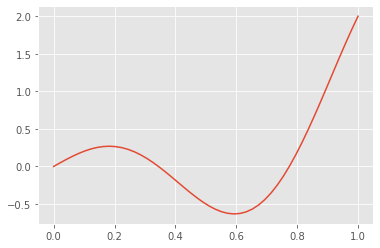

In [153]:
def f(x):
    return jnp.sin(2*jnp.pi*x)-3*jnp.cos(jnp.pi*x)*x - x
plt.plot(np.linspace(0,1,50),f(np.linspace(0,1,50)))

c = 2.1
def u(t,x):
    return f(x - c*t)

num_grid_points = 21
t,x = np.meshgrid(np.linspace(0,2,num_grid_points),np.linspace(0,1,num_grid_points))
tx_grid = np.vstack([t.flatten(),x.flatten()]).T

u_true = u(t.flatten(),x.flatten())

In [191]:
x_t_vals = tx_grid
#Give data on left boundary

boundary_obs_inds = []#list(range(0,20,1))
num_boundary = len(boundary_obs_inds)
num_obs = 60

np.random.seed(15)
x_t_sample_inds = np.random.choice(range(20,len(tx_grid)),num_obs - num_boundary,replace = False)
obs_inds = np.hstack([boundary_obs_inds,x_t_sample_inds]).astype(int)


tx_obs = tx_grid[obs_inds]

u_obs = u_true[obs_inds]
# plt.tricontourf(tx_obs[:,0],tx_obs[:,1],u_obs)
# plt.scatter(tx_obs[:,0],tx_obs[:,1])


k_u = get_gaussianRBF(0.1)

#Define k_P later

In [192]:
u_operators = [eval_k,dx_k,dt_k]
feature_operators = [eval_k,dx_k,dxx_k]

num_u = len(tx_grid)*len(u_operators)
num_p = len(tx_grid)


coeffs_u = np.zeros(len(tx_grid)*len(u_operators))
K = get_kernel_block_ops(k_u,feature_operators,u_operators,1)(tx_grid,tx_grid)
features = (K@coeffs_u).reshape(len(tx_grid),len(feature_operators),order = 'F')

coeffs_P = np.zeros(num_p)

In [193]:
def get_residual_function(tx_obs,tx_grid,u_observed_values,data_weight = 50):
    @jit
    def get_grid_features(coeffs_u):
        K_grid = get_kernel_block_ops(k_u,feature_operators,u_operators,1)(tx_grid,tx_grid)
        grid_features = (K_grid@coeffs_u).reshape(len(tx_grid),len(feature_operators),order = 'F')
        return grid_features

    @jit
    def residual_func(coeffs_u,coeffs_P):
        data_evals = get_kernel_block_ops(k_u,[eval_k],u_operators,1)(tx_obs,tx_grid)@coeffs_u
        datafit_residuals = u_observed_values - data_evals
        
        grid_target = get_kernel_block_ops(k_u,[dt_k],u_operators,1)(tx_grid,tx_grid)@coeffs_u
        grid_features = get_grid_features(coeffs_u)

        P_kmat = get_kernel_block_ops(k_P,[eval_k],[eval_k],1)(grid_features,grid_features)
        grid_preds = P_kmat@coeffs_P
        equation_residuals = (grid_target - grid_preds)
        
        return jnp.hstack([data_weight * datafit_residuals/np.sqrt(len(tx_obs)),equation_residuals/np.sqrt(len(tx_grid))])
    return residual_func,get_grid_features


residual_function,get_grid_features = get_residual_function(
    tx_obs,tx_grid,u_observed_values=u_obs,
    data_weight = 50
    )

def full_residual_function(combined_variables):
    coeffs_u = combined_variables[:num_u]
    coeffs_P = combined_variables[num_u:]
    return residual_function(coeffs_u,coeffs_P)



def loss(combined_variables):
    return (1/2)*jnp.linalg.norm(full_residual_function(combined_variables))**2


res_func = jax.jit(full_residual_function)
jac_res_func = jax.jit(jacrev(full_residual_function))
grad_func = jax.jit(grad(loss))

In [194]:
Keval_points = get_kernel_block_ops(k_u,[eval_k],u_operators,1)(tx_obs,tx_grid)
Kgrid_grid = get_kernel_block_ops(k_u,u_operators,u_operators,1)(tx_grid,tx_grid)
u_Kgrid_grid = Kgrid_grid + 1e-4*np.diag(np.diag(Kgrid_grid))

In [214]:
coeffs_u_initial = np.linalg.solve(Keval_points.T@Keval_points + 1e-4*Kgrid_grid,Keval_points.T@u_obs)


kmat = get_kernel_block_ops(k_u,[eval_k],u_operators,1)(tx_grid,tx_grid)
k_cheat = kmat.T@kmat
u_params_cheat = solve(k_cheat + 1e-5 * jnp.diag(jnp.diag(k_cheat)),kmat.T@u_true)
coeffs_u_initial = u_params_cheat

coeffs_u = u_params_cheat.copy()
grid_target = get_kernel_block_ops(k_u,[dt_k],u_operators,1)(tx_grid,tx_grid)@coeffs_u

K_grid = get_kernel_block_ops(k_u,feature_operators,u_operators,1)(tx_grid,tx_grid)

grid_features_init = (K_grid@coeffs_u).reshape(len(tx_grid),len(feature_operators),order = 'F')

coeffs_P = np.zeros(num_p)
params_init = jnp.hstack([coeffs_u,coeffs_P])

In [215]:
A_kernel_scaling = jnp.linalg.inv((jnp.cov(grid_features_init.T)))
k_P = get_anisotropic_gaussianRBF(0.15,A_kernel_scaling)

In [216]:
class EqnModel():    
    @jit
    def F(p):
        return full_residual_function(p)
    
    jac = jit(jacrev(F))
    feature_kmat = jit(get_kernel_block_ops(k_P,[eval_k],[eval_k],1))
    
    @jit
    def damping_matrix(p):
        grid_feats = get_grid_features(p[:num_u])
        feat_Kmat = EqnModel.feature_kmat(grid_feats,grid_feats)
        dmat = block_diag(
            u_Kgrid_grid,
            1e-2 * (feat_Kmat+1e-5 * np.identity(num_p))
        )
        return dmat

Text(0, 0.5, '$\\hat u_t$')

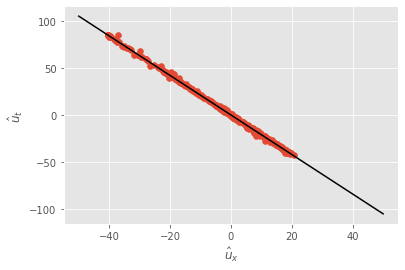

In [217]:
grid_target = get_kernel_block_ops(k_u,[dt_k],u_operators,1)(tx_grid,tx_grid)@coeffs_u

K_grid = get_kernel_block_ops(k_u,feature_operators,u_operators,1)(tx_grid,tx_grid)
grid_features = (K_grid@coeffs_u).reshape(len(tx_grid),len(feature_operators),order = 'F')


plt.scatter(grid_features[:,1],grid_target)
plt.plot([-50,50],[-c*-50,-c*50],c='black')
plt.xlabel("$\hat u_x$")
plt.ylabel("$\hat u_t$")

In [218]:
def get_rel_error(u_params):
    u_grid_vals_opt = get_kernel_block_ops(k_u,[eval_k],u_operators,1)(tx_grid,tx_grid)@u_params
    rel_error_opt = np.linalg.norm(u_grid_vals_opt - u_true)/np.linalg.norm(u_true)
    return rel_error_opt

def rel_error_callback(params):
    print(f"Relative error: {get_rel_error(params[:num_u])}")

In [219]:
print("Initial error of interpolant: ",get_rel_error(coeffs_u_initial))

Initial error of interpolant:  0.002591501878657149


In [220]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize


params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    0.,
    max_iter = 501,
    callback = rel_error_callback,
    print_every=5,
    init_alpha = 3.
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 535.1, Jres = 832.5
Relative error: 0.05463410170940525
Iteration 1, loss = 456.4, Jres = 1.38e+03
Relative error: 0.049371854527133795
Iteration 2, loss = 278.2, Jres = 1.279e+03
Relative error: 0.06037368730097377
Iteration 3, loss = 211.0, Jres = 1.345e+03
Relative error: 0.057047074134068634
Iteration 4, loss = 131.6, Jres = 1.93e+03
Relative error: 0.05267248093834271
Iteration 5, loss = 58.44, Jres = 2.252e+03
Relative error: 0.04983385609438249
Iteration 10, loss = 15.23, Jres = 304.4
Relative error: 0.04037051183606906
Iteration 15, loss = 13.25, Jres = 155.3
Relative error: 0.039649097797239824
Iteration 20, loss = 11.5, Jres = 172.6
Relative error: 0.03897132387350601
Iteration 25, loss = 9.987, Jres = 90.25
Relative error: 0.038174697341911326
Iteration 30, loss = 7.904, Jres = 45.12
Relative error: 0.037263250268618896
Iteration 35, loss = 5.523, Jres = 20.44
Relative error: 0.03616819003955031
Iteration 40, loss = 3.884, Jres = 3.952
Relative error: 0.0

(0.0, 2.0)

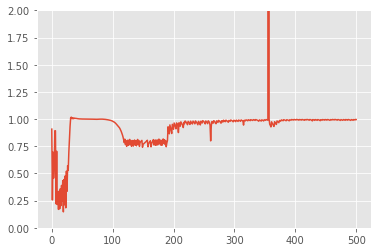

In [222]:
plt.plot(improvement_ratios)
plt.ylim(0,2)

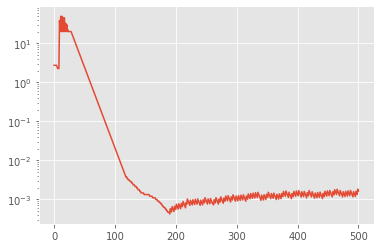

In [223]:
plt.plot(alpha_vals)
plt.yscale('log')

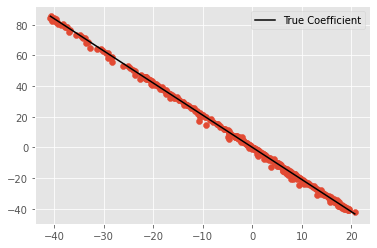

In [224]:
eq_model_params = params[num_u:]
coeffs_u = params[:num_u]
grid_target = get_kernel_block_ops(k_u,[dt_k],u_operators,1)(tx_grid,tx_grid)@coeffs_u

K_grid = get_kernel_block_ops(k_u,feature_operators,u_operators,1)(tx_grid,tx_grid)
grid_features = (K_grid@coeffs_u).reshape(len(tx_grid),len(feature_operators),order = 'F')

new_P_coeffs = np.linalg.lstsq(grid_features,grid_target,rcond=None)[0]
plt.scatter(grid_features[:,1],grid_target)

minval= np.min(grid_features[:,1])
maxval = np.max(grid_features[:,1])
plt.plot([minval,maxval],[-c*minval,-c*maxval],c='black',label = "True Coefficient")
#plt.plot([minval,maxval],[new_P_coeffs[1]*minval,new_P_coeffs[1]*maxval],c='blue',label = "Learned Coefficient")
plt.legend()

In [231]:
#There's a better way to do this without comprehension, but jax was being annoying
ut_true = jnp.array([grad(u,0)(tval,xval) for tval,xval in zip(t.flatten(),x.flatten())])
ut_MSE  = jnp.mean((EqnModel.feature_kmat(grid_features,grid_features)@eq_model_params - ut_true)**2)/jnp.mean(((ut_true)**2))

coeffs_u_initial = np.linalg.solve(Keval_points.T@Keval_points + 1e-4*Kgrid_grid,Keval_points.T@u_obs)
grid_target_init = get_kernel_block_ops(k_u,[dt_k],u_operators,1)(tx_grid,tx_grid)@coeffs_u_initial

init_ut_MSE = jnp.mean((grid_target_init - ut_true)**2)/jnp.mean(((ut_true)**2))

In [232]:
print("Initial Equation Learning Normalized MSE for predicting ut on the whole grid:")
print(init_ut_MSE)

print("Final Equation Learning Normalized MSE for predicting ut on the whole grid:")
print(ut_MSE)

Initial Equation Learning Normalized MSE for predicting ut on the whole grid:
0.07746849575290074
Final Equation Learning Normalized MSE for predicting ut on the whole grid:
0.0005650949426237587


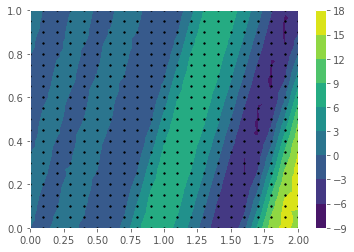

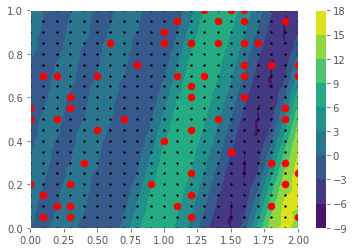

In [233]:
u_params = params[:num_u]
u_grid_vals_opt = get_kernel_block_ops(k_u,[eval_k],u_operators,1)(tx_grid,tx_grid)@u_params
plt.tricontourf(tx_grid[:,0],tx_grid[:,1],u_grid_vals_opt)
plt.colorbar()
plt.scatter(tx_grid[:,0],tx_grid[:,1],c='black',s = 3)
plt.show()
plt.tricontourf(tx_grid[:,0],tx_grid[:,1],u_true)
plt.colorbar()
plt.scatter(tx_grid[:,0],tx_grid[:,1],c='black',s = 3)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50)

plt.show()

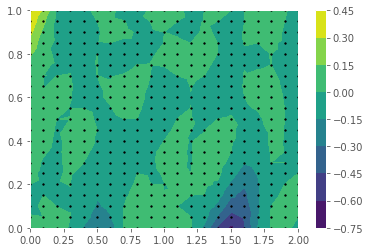

In [234]:
plt.tricontourf(tx_grid[:,0],tx_grid[:,1],u_true-u_grid_vals_opt)
plt.colorbar()
plt.scatter(tx_grid[:,0],tx_grid[:,1],c='black',s = 3)
plt.show()